In [1]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pymc as pm
import arviz as az
from quap import quap
import warnings
warnings.filterwarnings("ignore")

%config InlineBackend.figure_format = 'svg'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

In [2]:
df = pd.read_csv("Data/Howell1.csv", sep=";", header=0)
df

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0
542,71.120,8.051258,0.0,1


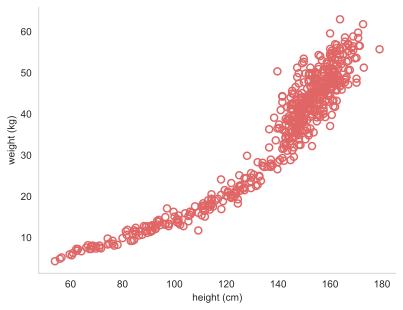

In [3]:
sns.scatterplot(x=df.height, y=df.weight, color="#e06666", edgecolor="#e06666", facecolor='none', s=50, linewidth=1.5)
plt.xlabel("height (cm)")
plt.ylabel("weight (kg)")
plt.grid(False)
sns.despine()

In [4]:
# adults only
df_adult = df[df.age >= 18]
df_adult

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
534,162.560,47.031821,27.0,0
537,142.875,34.246196,31.0,0
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0


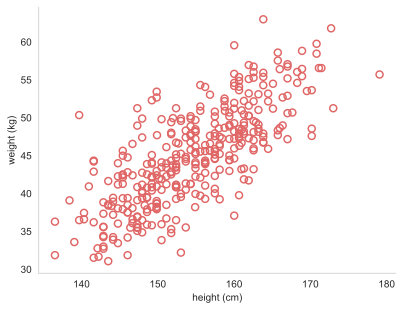

In [5]:
sns.scatterplot(x=df_adult.height, y=df_adult.weight, color="#e06666", edgecolor="#e06666", facecolor='none', s=50, linewidth=1.5)
plt.xlabel("height (cm)")
plt.ylabel("weight (kg)")
plt.grid(False)
sns.despine()

## Describe association between ADULT weight and height
Linear regression, $y_i = \alpha + \beta x_i$, $\alpha$ = intercept, $\beta$ = slope
$y_i \sim Normal(\mu_i, \sigma)$, $\mu_i = \alpha + \beta x_i$

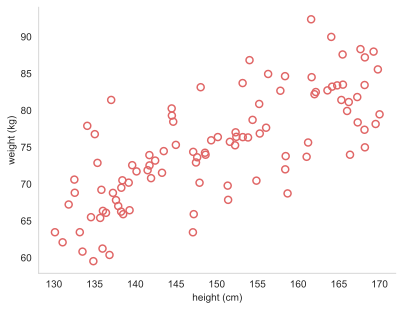

In [6]:
# generative model: H -> W
alpha = 0
beta = 0.5
sigma = 5
n = 100

# generate random heights (130-170)
height = stats.uniform.rvs(130, 40, n)
mu = alpha + beta * height
weight = stats.norm.rvs(mu, sigma)

sns.scatterplot(x=height, y=weight, color="#e06666", edgecolor="#e06666", facecolor='none', s=50, linewidth=1.5)
plt.xlabel("height (cm)")
plt.ylabel("weight (kg)")
plt.grid(False)
sns.despine()

## Linear Model
$y_i \sim Normal(\mu_i, \sigma)$,  
$\mu_i = \alpha + \beta x_i$,  
$\alpha \sim Normal()$,  
$\beta \sim Normal()$,  
$\sigma \sim Uniform()$   

Text(0, 0.5, 'y')

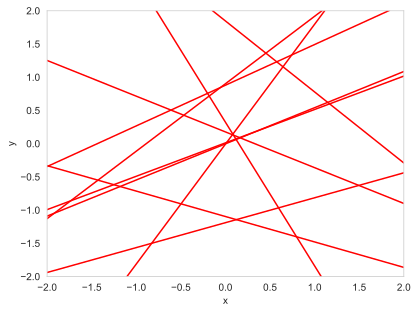

In [7]:
n_samples = 10
alpha = stats.norm.rvs(0, 1, n_samples)
beta = stats.norm.rvs(0, 1, n_samples)

plt.xlim((-2, 2))
plt.ylim((-2, 2))
for i in range(n_samples):
    axes = plt.gca()  # get current axes
    x_vals = np.array(axes.get_xlim())
    y_vals = alpha[i] + beta[i] * x_vals
    plt.plot(x_vals, y_vals, 'r')  # red line

plt.grid(False)
plt.xlabel("x")
plt.ylabel("y")

Re-scaling height so that the intercept has easily interpretable value.  
$W_i \sim Normal(\mu_i, \sigma)$,  
$\mu_i = \alpha + \beta (H_i - \bar H)$,  
What are scientific reasonable priors?
$\alpha \sim Normal(60, 10)$,  
$\beta \sim LogNormal(0, 1)$,  
$\sigma \sim Uniform(0, 10)$   

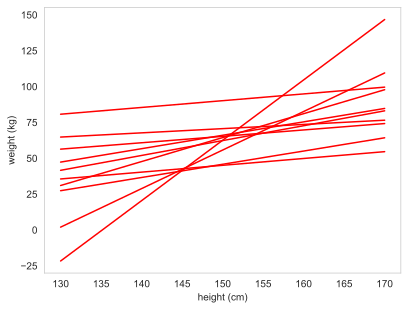

In [8]:
n_samples = 10
alpha = stats.norm.rvs(60, 10, n_samples)
beta = stats.lognorm.rvs(s=1, loc=0, size=n_samples)

Hbar = 150
Hseq = np.linspace(130, 170, 30)
for i in range(n_samples):
    plt.plot(Hseq, alpha[i] + beta[i] * (Hseq - Hbar), 'r')

plt.xlabel("height (cm)")
plt.ylabel("weight (kg)")
plt.grid(False)

## Quadratic Approximation
Many posterior distributions are approximately normal. Instead of grid approximation, we can use **quadratic approximation**. To use quadratic approximation, distribution's PDF must be smooth and well-peaked around maximum pont.

## Model Validation

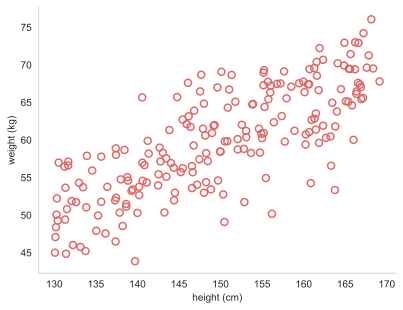

In [9]:
alpha = 60
beta = 0.5
sigma = 5
n_individuals = 200
H = stats.uniform.rvs(130, 40, n_individuals)
mu = alpha + beta * (H - H.mean())
W = stats.norm.rvs(mu, sigma, n_individuals)

sns.scatterplot(x=H, y=W, color="#e06666", edgecolor="#e06666", facecolor='none', s=50, linewidth=1.5)
plt.xlabel("height (cm)")
plt.ylabel("weight (kg)")
plt.grid(False)
sns.despine()

In [10]:
with pm.Model() as m_real:
    a = pm.Normal("a", mu=60, sigma=10)
    b = pm.Lognormal("b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    mu = pm.Deterministic("mu", a + b * (H - H.mean()))
    weight = pm.Normal("weight", mu=mu, sigma=sigma, observed=W)
    
    idata, possterior = quap([a, b, sigma], n_samples=10000)

In [11]:
az.summary(idata, kind="stats")

,mean,sd,hdi_3%,hdi_97%
a,59.894,0.315,59.305,60.490
b,0.485,0.059,0.373,0.595
sigma,4.489,0.090,4.323,4.657


## Real Data Model Fitting

In [12]:
d = pd.read_csv("Data/Howell1.csv", sep=";", header=0)
d = d[d.age >= 18]
H = d.height
W = d.weight

In [13]:
with pm.Model() as m_real:
    a = pm.Normal("a", mu=60, sigma=10)
    b = pm.Lognormal("b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    mu = pm.Deterministic("mu", a + b * (H - H.mean()))
    weight = pm.Normal("weight", mu=mu, sigma=sigma, observed=W)
    
    idata, possterior = quap([a, b, sigma], n_samples=10000)

In [14]:
az.summary(idata, kind="stats")

,mean,sd,hdi_3%,hdi_97%
a,44.997,0.225,44.556,45.402
b,0.628,0.046,0.545,0.718
sigma,4.230,0.065,4.115,4.360


The parameters are not independent.

In [15]:
ds = az.extract(idata)
samples = ds.to_dataframe()
samples.head()

a         b     sigma  chain  draw
chain draw                                            
0     0     45.062239  0.637089  4.295941      0     0
      1     45.164756  0.681994  4.347910      0     1
      2     45.328122  0.621179  4.203497      0     2
      3     44.918715  0.616684  4.278884      0     3
      4     45.319181  0.624023  4.265835      0     4

## Posterior Predictive Checks

### Plot the observed data

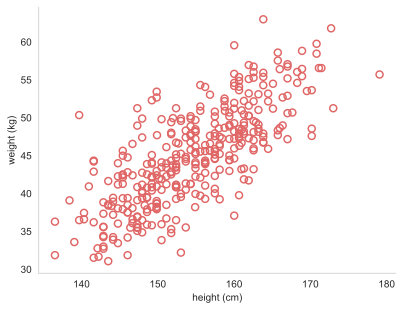

In [16]:
plt.scatter(H, W, facecolors='none', edgecolors="#e06666", s=50, linewidth=1.5)
plt.xlabel("height (cm)")
plt.ylabel("weight (kg)")
plt.grid(False)
sns.despine()

### Plot the posterior mean

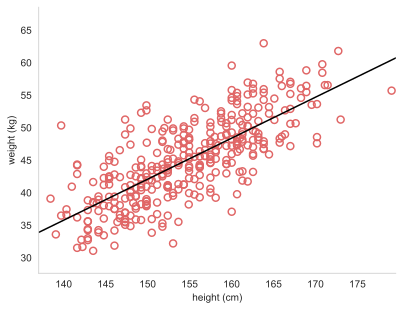

In [17]:
height_seq = np.arange(130, 190)
# get 1000 samples from the posterior
idata_thinned = az.extract(idata, num_samples=1000)
# expected weights
mu_pred = np.zeros((len(height_seq), idata_thinned.sizes["sample"]))
a_value = idata_thinned.a.values
b_value = idata_thinned.b.values

for i, h in enumerate(height_seq):
    mu_pred[i] = a_value + b_value * (h - H.mean())

mu_mean = mu_pred.mean(axis=1)

plt.scatter(H, W, facecolors='none', edgecolors="#e06666", s=50, linewidth=1.5)
plt.xlabel("height (cm)")
plt.ylabel("weight (kg)")
plt.plot(height_seq, mu_mean, 'black')
plt.xlim(H.min() + 0.5, H.max() + 0.5)
plt.grid(False)
sns.despine()

### Plot uncertainty of the mean
Plots the range of values in heighest density interval (HDI) for each height.

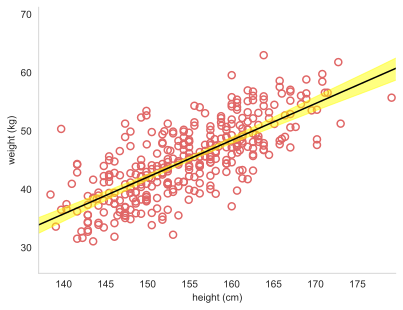

In [18]:
plt.scatter(H, W, facecolors='none', edgecolors="#e06666", s=50, linewidth=1.5)
plt.xlabel("height (cm)")
plt.ylabel("weight (kg)")
plt.plot(height_seq, mu_mean, 'k')
ax = az.plot_hdi(height_seq, mu_pred.T, hdi_prob=0.89, color='yellow')
plt.xlim(H.min() + 0.5, H.max() + 0.5)
plt.grid(False)
sns.despine()

### Plot uncertainty of predictions

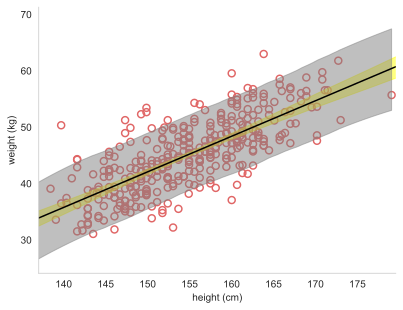

In [19]:
idata_thinned = az.extract(idata, num_samples=1000)
# expected weights computed based on the observed heights and sampled parameters
mu_pred_obs = np.zeros((len(H), idata_thinned.sizes["sample"]))

a_value = idata_thinned.a.values
b_value = idata_thinned.b.values
sigma_value = idata_thinned.sigma.values

weight_pred = np.zeros((len(H), idata_thinned.sizes["sample"]))

for i, h in enumerate(H):
    mu_pred_obs[i] = a_value + b_value * (h - H.mean())
    weight_pred[i] = stats.norm.rvs(mu_pred_obs[i], sigma_value)
    
plt.scatter(H, W, facecolors='none', edgecolors="#e06666", s=50, linewidth=1.5)
plt.xlabel("height (cm)")
plt.ylabel("weight (kg)")
plt.plot(height_seq, mu_mean, 'k')
ax = az.plot_hdi(height_seq, mu_pred.T, hdi_prob=0.89, color='yellow')
ax = az.plot_hdi(H, weight_pred.T, hdi_prob=0.89, color='gray')
plt.xlim(H.min() + 0.5, H.max() + 0.5)
plt.grid(False)
sns.despine()